# Accessing and Processing the Optical Absorption and Attenuation (OPTAA) Data from OOI

OOI uses the [Sea-Bird Electronics, AC-S In-Situ Spectrophotometer](https://www.seabird.com/ac-s-spectral-absorption-and-attenuation-sensor/product?id=60762467715) to measure the in situ absorption and beam attenuation coefficients from approximately 400 to 750 nm at a 4 nm resolution. Each sensor is equipped with a unique filter set that determines the exact wavelengths measured and the total number of wavelengths measured. This difference in the number of measured wavelengths and, to a certain extent, their specific values can cause complications when trying to compare measurements across deployments. One solution, presented here, is to reset the number of wavelengths for each unique instrument/deployment instance using fill values to pad out the number of wavelengths and the absorption and beam attenuation measurements to a fixed number of wavelengths. This creates a common dimension for the number of wavelengths that can be used when subsequently concatenating data across deployments.

An additional issue is the volume of data produced by the sensor. A full deployment's worth of data can get rather unwieldy. Per a recommendation from the vendor, the first 60 seconds worth of data should be discarded after an instrument starts up. Dropping those records will help to reduce the volume of the data. We can also use burst averaging to further reduce the volume. Burst averaging has an added benefit in helping to reduce some of the point-to-point noisiness that is common in bio-optical data (biology is messy!).

In [1]:
%matplotlib inline

# load the different libraries and modules needed for the analysis
import csv
import io
import numpy as np
import os
import pandas as pd
import xarray as xr

from ooi_data_explorations.common import load_gc_thredds
from pyseas.data.opt_functions import opt_internal_temp, opt_external_temp

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

For this example, we'll look at the data from Deployment 3 of the Oregon Shelf Surface Mooring. The instrument failed after approximately 8 weeks into the deployment, so this is not a full deployments worth of data. This particular instrument is run once an hour for >2 minutes at ~4 Hz. Each measurement cycle represents a burst measurement.

Rather than requesting the data from the M2M interface, we'll request the data from the [OOI Gold Copy THREDDS server](https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/catalog.html). This data is pulled from the M2M system by automated processes on a regular schedule, and is used as the backend data source for [Data Explorer](https://dataexplorer.oceanobservatories.org/). Pulling this pre-computed and organized data, compared to issuing an M2M data request, waiting while the data is collected and processed, and then downloading the results, can represent a significant time-savings for the researcher (on the order of hours for some of the larger, more complex data sets). The functions used to access the data from the Gold Copy can be found and described in the python section of the [OOI Data Explorations](https://github.com/oceanobservatories/ooi-data-explorations/tree/master/python) GitHub repository.

In [2]:
# Setup needed parameters for the request
site = 'CE02SHSM'           # OOI Net site designator
node = 'RID27'              # OOI Net node designator
sensor = '01-OPTAAD000'     # OOI Net sensor designator
stream = 'optaa_dj_dcl_instrument_recovered'  # OOI Net stream name
method = 'recovered_host'      # OOI Net data delivery method
tag = '.*deployment0003.*OPTAA.*\\.nc$'  # limit request to OPTAA NetCDF files from Deployment 3

# download the data from the OOI Gold Copy THREDDS server
data = load_gc_thredds(site, node, sensor, method, stream, tag)

Waiting: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [08:43<00:00, 104.72s/it]


Per the vendor recommendation we'll drop the first 60 seconds worth of data and then we'll average each burst. Note, more recently, the vendor has recommended dropping the first 2 minutes worth of data, but the instrument was operated for several deployment cycles using a 2-minute burst duration schedule. If we delete the first two minutes worth of data, we would delete the entire burst. For now, we'll just use the initial recommendation.

In [3]:
# Delete the first 60 seconds of the data record per recommendation from the vendor
data.elapsed_run_time.values = data.elapsed_run_time.where(data.elapsed_run_time / 1000 > 60)
data = data.dropna(dim='time', subset=['elapsed_run_time'])
data = data.sortby('time')

In [5]:
# median average each burst, centering the window on the time range of interest (default is left shifted)
burst = data.resample(time='900s', base=3150, loffset='450s', skipna=True).median(keep_attrs=True)
burst = burst.where(~np.isnan(burst.deployment), drop=True)
burst

<xarray.Dataset>
Dimensions:                  (time: 1165, wavelength: 81)
Coordinates:
  * time                     (time) datetime64[ns] 2016-05-23T00:30:00 ... 20...
  * wavelength               (wavelength) int32 0 1 2 3 4 5 ... 76 77 78 79 80
Data variables: (12/20)
    external_temp_raw        (time) float32 3.884e+04 3.879e+04 ... 3.713e+04
    elapsed_run_time         (time) float64 1.172e+05 1.163e+05 ... 1.075e+05
    internal_temp_raw        (time) float32 5.017e+04 5.015e+04 ... 4.919e+04
    c_reference_dark_counts  (time) float32 472.0 472.0 ... 1.157e+04 1.441e+04
    num_wavelengths          (time) float32 81.0 81.0 81.0 ... 81.0 81.0 81.0
    deployment               (time) float64 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
    ...                       ...
    c_signal_counts          (time, wavelength) float32 811.0 968.0 ... 77.0
    a_signal_counts          (time, wavelength) float32 1.395e+03 ... 1.0
    a_reference_counts       (time, wavelength) float32 968.0 1.096e+03 ... 1.0
    c_reference_counts       (time, wavelength) float32 733.0 836.0 ... 1.0 1.0
    beam_attenuation         (time, wavelength) float64 nan 0.3636 ... -15.34
    optical_absorption       (time, wavelength) float64 nan 0.2096 ... 1.88
Attributes: (12/69)
    node:                               RID27
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             optaa_dj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                44.63565
    lon:                                -124.30427

The data needs some slight re-organization so it can be used across deployments and sites. Specifically, each OPTAA will have a different number of wavelengths, based on the specific filter set used in the instrument. In order to merge the data across deployments and sites, the number of wavelengths needs to be padded to a common number (we'll use 100 since the instruments all measure between 80 and 90 wavelengths).

In [6]:
# create an xarray dataset of the 2D variables, padding the number of wavelengths to a consistent 
# length of 100 using fill values.
wavelength_number = np.arange(100).astype(np.int32)  # used as a dimensional variable
num_wavelengths = burst.num_wavelengths.values[0].astype(np.int32)
pad = 100 - num_wavelengths
fill_nan = np.tile(np.ones(pad) * np.nan, (len(burst.time), 1))
fill_int = np.tile(np.ones(pad) * -9999999, (len(burst.time), 1))

wavelength_a = np.concatenate([burst.wavelength_a.values, fill_nan], axis=1)
wavelength_c = np.concatenate([burst.wavelength_c.values, fill_nan], axis=1)

ac = xr.Dataset({
    'wavelength_a': (['time', 'wavelength'], wavelength_a),
    'a_signal_counts': (['time', 'wavelength'], np.concatenate([burst.a_signal_counts.astype(np.int32),
                                                                       fill_int], axis=1)),
    'a_reference_counts': (['time', 'wavelength'], np.concatenate([burst.a_reference_counts.astype(np.int32),
                                                                          fill_int], axis=1)),
    'optical_absorption': (['time', 'wavelength'], np.concatenate([burst.optical_absorption, fill_nan], 
                                                                         axis=1)),
    'wavelength_c': (['time', 'wavelength'], wavelength_c),
    'c_signal_counts': (['time', 'wavelength'], np.concatenate([burst.c_signal_counts.astype(np.int32),
                                                                       fill_int], axis=1)),
    'c_reference_counts': (['time', 'wavelength'], np.concatenate([burst.c_reference_counts.astype(np.int32),
                                                                          fill_int], axis=1)),
    'beam_attenuation': (['time', 'wavelength'], np.concatenate([burst.beam_attenuation, fill_nan], 
                                                                       axis=1))
}, coords={'time': (['time'], burst.time.values), 'wavelength': wavelength_number})

In [7]:
# drop the original 2D variables from the burst data set
drop = burst.drop(['wavelength_a', 'a_signal_counts', 'a_reference_counts', 'optical_absorption',
                    'wavelength_c', 'c_signal_counts', 'c_reference_counts', 'beam_attenuation'])

# if we used burst averaging, reset the data type for the 'a' and 'c' signal and reference 
# dark values, and the other raw parameters
int_arrays = ['a_signal_dark_counts', 'a_reference_dark_counts', 'c_signal_dark_counts', 
              'c_reference_dark_counts', 'internal_temp_raw', 'external_temp_raw', 
              'pressure_counts', 'num_wavelengths', 'deployment']
for k in drop.variables:
    if k in int_arrays:
        drop[k] = drop[k].astype(np.int32)

# recombine the two datasets
optaa = xr.merge([drop, ac])

# reset the attributes, which the merging drops
optaa.attrs = data.attrs
for v in optaa.variables:
    optaa[v].attrs = data[v].attrs

If the data from a co-located CTD is missing (instrument or telemetry failed), then the parameters `temp` and `practical_salinity` will be missing as well as the derived `optical_absorption` and `beam_attenuation` parameters which require temperature and salinity as inputs to the functions. The last step needed before cross-comparisons (between deployments or sites) is to check for the presence of these values and, if they are missing, create them using NaNs as a fill value.

In [8]:
# check for data from a co-located CTD, if not present add with the appropriate attributes
if 'temp' not in optaa.variables:
    optaa['temp'] = ('time', optaa['deployment'] * np.nan)
    optaa['temp'].attrs = {
        'long_name': 'Seawater Temperature',
        'standard_name': 'sea_water_temperature',
        'units': 'degree_Celsius',
        'comment': ('Normally this would be seawater temperature data from a co-located CTD. However, data from ' +
                    'that sensor is unavailable. This value has been filled with NaNs to preserve the structure ' +
                    'of the data set.'),
        'data_product_identifier': 'TEMPWAT_L1',
    }

    optaa['practical_salinity'] = ('time', optaa['deployment'] * np.nan)
    optaa['practical_salinity'].attrs = {
        'long_name': 'Practical Salinity',
        'standard_name': 'sea_water_practical_salinity',
        'units': '1',
        'comment': ('Normally this would be seawater salinity data from a co-located CTD. However, data from ' +
                    'that sensor is unavailable. This value has been filled with NaNs to preserve the structure ' +
                    'of the data set.'),
        'data_product_identifier': 'PRACSAL_L2'
    }
    
    optaa['optical_absorption'] = (['time, wavelength'], a_signal_counts * np.nan)
    optaa['beam_attenuation'] = (['time, wavelength'], c_signal_counts * np.nan)

## Save the data for future work

At this point the optaa record is at a point where it can be saved locally or used in further work looking across deployments or between sites.

Some of the work one might want to do is a review of the data by comparing the instrument temperature records versus the co-located CTD data, by computing different parameters (chlorophyll concentration, POC, and absorption ratios) from the absorption and attenuation records and by reviewing the shape and magnitude of the aborption and attenuation spectra.

In [9]:
# convert internal and external temperature sensors from raw counts to degrees Celsius
optaa['internal_temp'] = opt_internal_temp(optaa['internal_temp_raw'])
optaa['external_temp'] = opt_external_temp(optaa['external_temp_raw'])

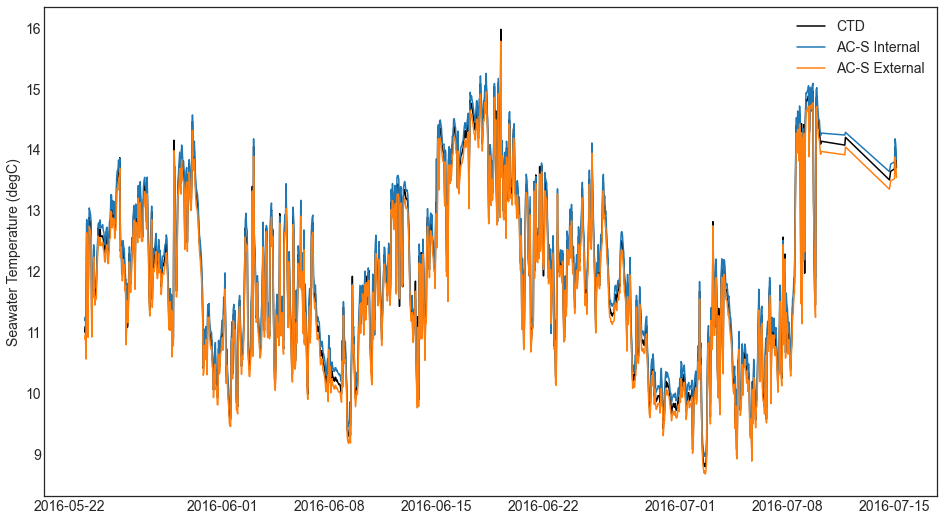

In [10]:
%matplotlib inline

# Plot the instrument and co-located CTD temperature records
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))
plt.plot(optaa['time'], optaa['temp'], '-k', label='CTD')
plt.plot(optaa['time'], optaa['internal_temp'], label='AC-S Internal')
plt.plot(optaa['time'], optaa['external_temp'], label='AC-S External')
plt.ylabel('Seawater Temperature (degC)')
plt.legend()

The CTD seawater temperature and the instrument internal temperature are inputs to the functions used to calculate the optical absorption and beam attenuation. The data from the external temperature sensor on the AC-S is not used, but it is should be producing values very close to the CTD (the AC-S temperaure sensor is not as accurate as the CTD). All three measurements should be very similar. If they are not, that would be a good indication that there is a problem with one of the sensors.

In [11]:
def estimate_chl_poc(optaa):
    """
    Derive estimates of Chlorophyll-a and particulate organic carbon (POC)
    concentrations from the temperature, salinity and scatter corrected
    absorption and beam attenuation data.

    :param optaa: xarray dataset with the scatter corrected absorbance data.
    :return optaa: xarray dataset with the estimates for chlorophyll and POC
        concentrations added.
    """
    # use the standard chlorophyll line height estimation with an extinction coefficient of 0.020.
    m676 = np.nanargmin(np.abs(optaa['wavelength_a'].values[0, :] - 676.0))
    m650 = np.nanargmin(np.abs(optaa['wavelength_a'].values[0, :] - 650.0))
    m715 = np.nanargmin(np.abs(optaa['wavelength_a'].values[0, :] - 715.0))
    apg = optaa['optical_absorption']
    aphi = apg[:, m676] - 39/65 * apg[:, m650] - 26/65 * apg[:, m715]
    optaa['estimated_chlorophyll'] = aphi / 0.020

    # estimate the POC concentration from the attenuation at 660 nm
    m660 = np.nanargmin(np.abs(optaa['wavelength_c'].values[0, :] - 660.0))
    cpg = optaa['beam_attenuation']
    optaa['estimated_poc'] = cpg[:, m660] * 380

    return optaa


def calculate_ratios(optaa):
    """
    Calculate pigment ratios to use in analyzing community composition and/or
    bloom health. As these ratios are subject to the effects of biofouling it
    is expected that these values will start to become chaotic with noise
    dominating the signal. Thus these ratios can also serve as biofouling
    indicators.

    :param optaa: xarray dataset with the scatter corrected absorbance data.
    :return optaa: xarray dataset with the estimates for chlorophyll and POC
        concentrations added.
    """
    apg = optaa['optical_absorption']
    m412 = np.nanargmin(np.abs(optaa['wavelength_a'].values[0, :] - 412.0))
    m440 = np.nanargmin(np.abs(optaa['wavelength_a'].values[0, :] - 440.0))
    m490 = np.nanargmin(np.abs(optaa['wavelength_a'].values[0, :] - 490.0))
    m530 = np.nanargmin(np.abs(optaa['wavelength_a'].values[0, :] - 530.0))
    m676 = np.nanargmin(np.abs(optaa['wavelength_a'].values[0, :] - 676.0))

    optaa['ratio_cdom'] = apg[:, m412] / apg[:, m440]
    optaa['ratio_carotenoids'] = apg[:, m490] / apg[:, m440]
    optaa['ratio_phycobilins'] = apg[:, m530] / apg[:, m440]
    optaa['ratio_qband'] = apg[:, m676] / apg[:, m440]

    return optaa

In [12]:
# Calculate the chlorophyll and particulate organic carbon (POC) concentrations and key pigment ratios
optaa = estimate_chl_poc(optaa)
optaa = calculate_ratios(optaa)

The AC-S data can be used to create estimates of the chlorophyll and particulate organic carbon (POC) concentration. These can be compared to data from a co-located fluorometer to help validate the performance of the sensors. Additionally, pigment ratios can be calculated to asses the impacts of biofouling, potential changes in community composition, light history or bloom health and age, .

* CDOM Ratio -- ratio of CDOM absorption in the violet portion of the spectrum at 412 nm relative to chlorophyll absorption at 440 nm. Ratios greater than 1 indicate a preponderance of CDOM absorption relative to chlorophyll.
* Carotenoid Ratio -- ratio of carotenoid absorption in the blue-green portion of the spectrum at 490 nm relative to chlorophyll absorption at 440 nm. A changing carotenoid to chlorophyll ratio may indicate a shift in phytoplankton community composition in addition to changes in light history or bloom health and age.
* Phycobilin Ratio -- ratio of phycobilin absorption in the green portion of the spectrum at 530 nm relative to chlorophyll absorption at 440 nm. Different phytoplankton, notably cyanobacteria, utilize phycobilins as accessory light harvesting pigments. An increasing phycobilin to chlorophyll ratio may indicate a shift in phytoplankton community composition.
* Q Band Ratio -- the Soret and the Q bands represent the two main absorption bands of chlorophyll. The former covers absorption in the blue region of the spectrum, while the latter covers absorption in the red region. A decrease in the ratio of the intensity of the Soret band at 440 nm to that of the Q band at 676 nm may indicate a change in phytoplankton community structure. All phytoplankton contain chlorophyll a as the primary light harvesting pigment, but green algae and dinoflagellates contain chlorophyll b and c, respectively, which are spectrally redshifted compared to chlorophyll a.

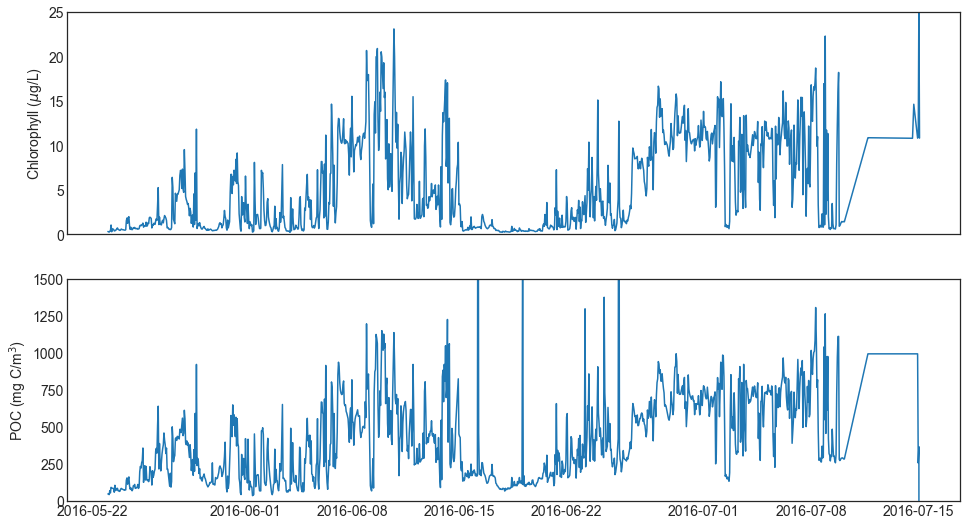

In [13]:
# plot the estimated chlorophyll and POC concentrations
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(211)
plt.plot(optaa['time'], optaa['estimated_chlorophyll'])
plt.ylabel('Chlorophyll ($\mu$g/L)')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 25])

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(optaa['time'], optaa['estimated_poc'])
plt.ylabel('POC (mg C/m$^3$)')
plt.ylim([0, 1500])
plt.show()

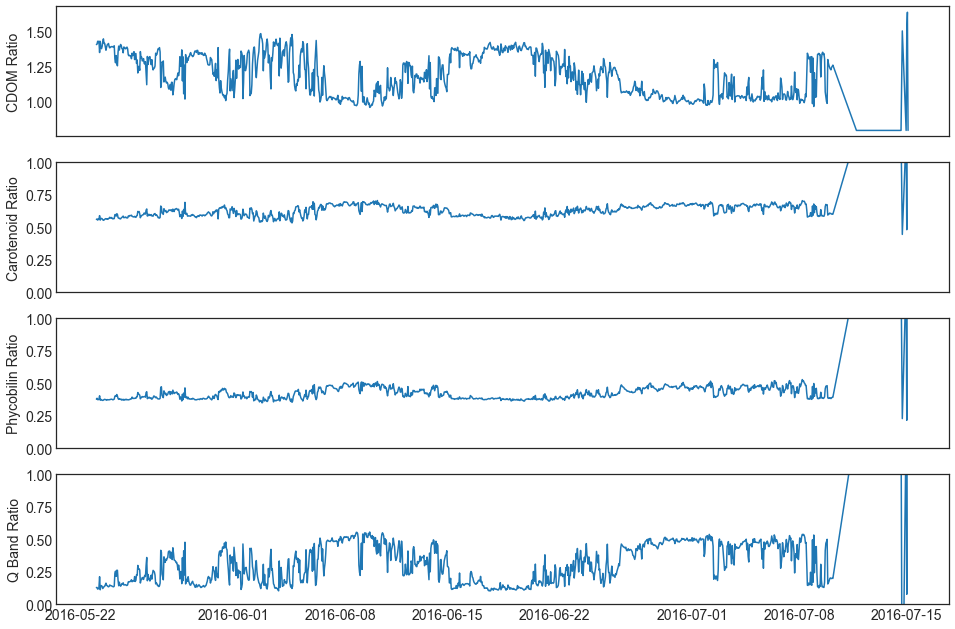

In [14]:
# plot the pigment ratios
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,11))

ax1 = plt.subplot(411)
plt.plot(optaa['time'], optaa['ratio_cdom'])
plt.ylabel('CDOM Ratio')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(412, sharex=ax1)
plt.plot(optaa['time'], optaa['ratio_carotenoids'])
plt.ylabel('Carotenoid Ratio')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 1])

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(optaa['time'], optaa['ratio_phycobilins'])
plt.ylabel('Phycobilin Ratio')
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 1])

ax4 = plt.subplot(414, sharex=ax1)
plt.plot(optaa['time'], optaa['ratio_qband'])
plt.ylabel('Q Band Ratio')
plt.ylim([0, 1])

plt.show()

Finally, examining the shape and magnitudes of the absorption and attenuation spectra can be helpful in assessing the instrument performance in addition to revealing interesting information about the in situ absorption and attenuation properties of the seawater.

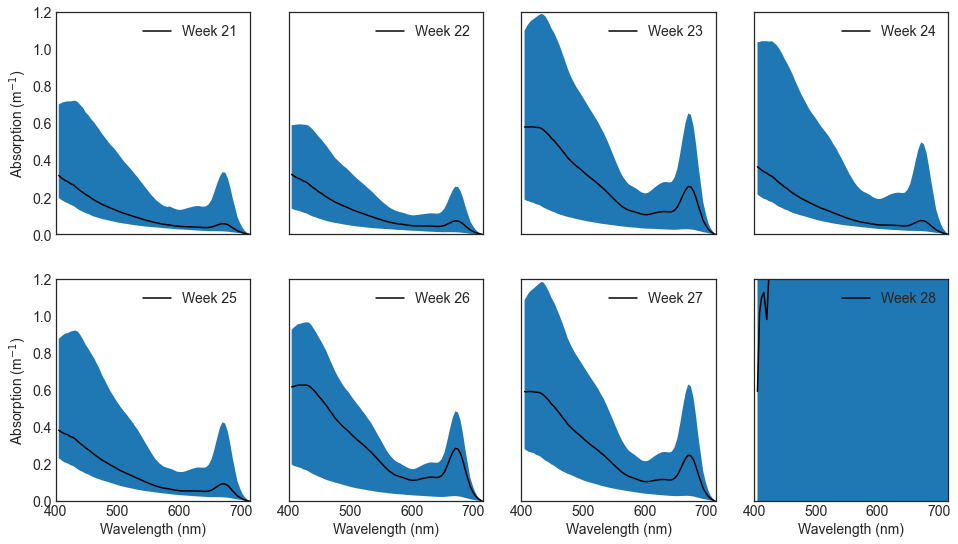

In [27]:
# create groups of data organized by the week
weeks = optaa.groupby('time.week').groups

# plot weekly summaries of the absorption spectra (the mean and the min and max range)
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(241)
week = optaa.isel(time=weeks[21])
plt.plot(week['wavelength_a'][0, :], week['optical_absorption'].mean(axis=0), '-k', label='Week 21')
plt.fill_between(week['wavelength_a'][0, :], week['optical_absorption'].min(axis=0), week['optical_absorption'].max(axis=0))
plt.ylim([0, 1.2])
plt.ylabel('Absorption (m$^{-1}$)')
plt.xlim([400, 715])
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.legend()

ax2 = plt.subplot(242, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[22])
plt.plot(week['wavelength_a'][0, :], week['optical_absorption'].mean(axis=0), '-k', label='Week 22')
plt.fill_between(week['wavelength_a'][0, :], week['optical_absorption'].min(axis=0), week['optical_absorption'].max(axis=0))
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax2.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax3 = plt.subplot(243, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[23])
plt.plot(week['wavelength_a'][0, :], week['optical_absorption'].mean(axis=0), '-k', label='Week 23')
plt.fill_between(week['wavelength_a'][0, :], week['optical_absorption'].min(axis=0), week['optical_absorption'].max(axis=0))
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax3.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax4 = plt.subplot(244, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[24])
plt.plot(week['wavelength_a'][0, :], week['optical_absorption'].mean(axis=0), '-k', label='Week 24')
plt.fill_between(week['wavelength_a'][0, :], week['optical_absorption'].min(axis=0), week['optical_absorption'].max(axis=0))
plt.setp(ax4.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax4.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax5 = plt.subplot(245, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[25])
plt.plot(week['wavelength_a'][0, :], week['optical_absorption'].mean(axis=0), '-k', label='Week 25')
plt.fill_between(week['wavelength_a'][0, :], week['optical_absorption'].min(axis=0), week['optical_absorption'].max(axis=0))
plt.ylabel('Absorption (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.legend()

ax6 = plt.subplot(246, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[26])
plt.plot(week['wavelength_a'][0, :], week['optical_absorption'].mean(axis=0), '-k', label='Week 26')
plt.fill_between(week['wavelength_a'][0, :], week['optical_absorption'].min(axis=0), week['optical_absorption'].max(axis=0))
plt.setp(ax6.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.xlabel('Wavelength (nm)')
plt.legend()

ax7 = plt.subplot(247, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[27])
plt.plot(week['wavelength_a'][0, :], week['optical_absorption'].mean(axis=0), '-k', label='Week 27')
plt.fill_between(week['wavelength_a'][0, :], week['optical_absorption'].min(axis=0), week['optical_absorption'].max(axis=0))
plt.setp(ax7.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.xlabel('Wavelength (nm)')
plt.legend()

ax8 = plt.subplot(248, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[28])
plt.plot(week['wavelength_a'][0, :], week['optical_absorption'].mean(axis=0), '-k', label='Week 28')
plt.fill_between(week['wavelength_a'][0, :], week['optical_absorption'].min(axis=0), week['optical_absorption'].max(axis=0))
plt.setp(ax8.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.xlabel('Wavelength (nm)')
plt.legend()

plt.show()

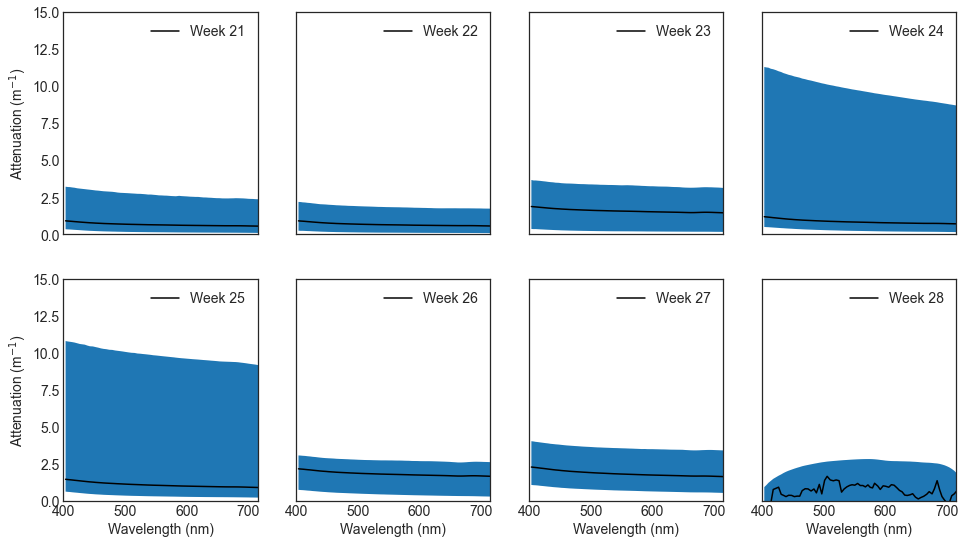

In [30]:
# plot weekly summaries of the attenuation spectra (the mean and the min and max range)
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(241)
week = optaa.isel(time=weeks[21])
plt.plot(week['wavelength_c'][0, :], week['beam_attenuation'].mean(axis=0), '-k', label='Week 21')
plt.fill_between(week['wavelength_c'][0, :], week['beam_attenuation'].min(axis=0), week['beam_attenuation'].max(axis=0))
plt.ylim([0, 15])
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlim([400, 715])
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.legend()

ax2 = plt.subplot(242, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[22])
plt.plot(week['wavelength_c'][0, :], week['beam_attenuation'].mean(axis=0), '-k', label='Week 22')
plt.fill_between(week['wavelength_c'][0, :], week['beam_attenuation'].min(axis=0), week['beam_attenuation'].max(axis=0))
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax2.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax3 = plt.subplot(243, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[23])
plt.plot(week['wavelength_c'][0, :], week['beam_attenuation'].mean(axis=0), '-k', label='Week 23')
plt.fill_between(week['wavelength_c'][0, :], week['beam_attenuation'].min(axis=0), week['beam_attenuation'].max(axis=0))
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax3.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax4 = plt.subplot(244, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[24])
plt.plot(week['wavelength_c'][0, :], week['beam_attenuation'].mean(axis=0), '-k', label='Week 24')
plt.fill_between(week['wavelength_c'][0, :], week['beam_attenuation'].min(axis=0), week['beam_attenuation'].max(axis=0))
plt.setp(ax4.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.setp(ax4.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.legend()

ax5 = plt.subplot(245, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[25])
plt.plot(week['wavelength_c'][0, :], week['beam_attenuation'].mean(axis=0), '-k', label='Week 25')
plt.fill_between(week['wavelength_c'][0, :], week['beam_attenuation'].min(axis=0), week['beam_attenuation'].max(axis=0))
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.legend()

ax6 = plt.subplot(246, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[26])
plt.plot(week['wavelength_c'][0, :], week['beam_attenuation'].mean(axis=0), '-k', label='Week 26')
plt.fill_between(week['wavelength_c'][0, :], week['beam_attenuation'].min(axis=0), week['beam_attenuation'].max(axis=0))
plt.setp(ax6.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.xlabel('Wavelength (nm)')
plt.legend()

ax7 = plt.subplot(247, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[27])
plt.plot(week['wavelength_c'][0, :], week['beam_attenuation'].mean(axis=0), '-k', label='Week 27')
plt.fill_between(week['wavelength_c'][0, :], week['beam_attenuation'].min(axis=0), week['beam_attenuation'].max(axis=0))
plt.setp(ax7.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.xlabel('Wavelength (nm)')
plt.legend()

ax8 = plt.subplot(248, sharex=ax1, sharey=ax1)
week = optaa.isel(time=weeks[28])
plt.plot(week['wavelength_c'][0, :], week['beam_attenuation'].mean(axis=0), '-k', label='Week 28')
plt.fill_between(week['wavelength_c'][0, :], week['beam_attenuation'].min(axis=0), week['beam_attenuation'].max(axis=0))
plt.setp(ax8.get_yticklabels(), visible=False) # turn off y-axis ticklabels
plt.xlabel('Wavelength (nm)')
plt.legend()

plt.show()